<a href="https://colab.research.google.com/github/deep-diver/auto-paper-analysis/blob/main/notebooks/analyze_arxiv_pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from IPython.display import HTML, display
from IPython.display import Markdown

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install google-generativeai
!pip install pypdf2
!pip install fitz
!pip install pymupdf

In [14]:
GEMINI_API_KEY="..."

In [3]:
import requests

def download_pdf_from_arxiv(arxiv_id):
  url = f'http://export.arxiv.org/pdf/{arxiv_id}'
  response = requests.get(url)
  if response.status_code == 200:
    return response.content
  else:
    raise Exception(f"Failed to download pdf for arXiv id {arxiv_id}")

# Example usage
arxiv_id = "2306.00001"
pdf_content = download_pdf_from_arxiv(arxiv_id)

# Save the pdf content to a file
with open(f"{arxiv_id}.pdf", "wb") as f:
  f.write(pdf_content)


In [4]:
import fitz  # PyMuPDF
import PyPDF2

def extract_text_and_figures(pdf_path):
    """
    Extracts text and figures from a PDF file.

    Args:
        pdf_path (str): The path to the PDF file.

    Returns:
        tuple: A tuple containing two lists:
            * A list of extracted text blocks.
            * A list of extracted figures (as bytes).
    """

    texts = []
    figures = []

    # Open the PDF using PyMuPDF (fitz) for image extraction
    doc = fitz.open(pdf_path)
    for page_num, page in enumerate(doc):
        text = page.get_text("text")  # Extract text as plain text
        texts.append(text)

        # Process images on the page
        image_list = page.get_images()
        for image_index, img in enumerate(image_list):
            xref = img[0]  # Image XREF
            pix = fitz.Pixmap(doc, xref)  # Create Pixmap image

            # Save image in desired format (here, PNG)
            if pix.n < 5:  # Grayscale or RGB
                img_bytes = pix.tobytes("png")
            else:  # CMYK: Convert to RGB first
                pix = fitz.Pixmap(fitz.csRGB, pix)
                img_bytes = pix.tobytes("png")

            figures.append(img_bytes)

    # Extract additional text using PyPDF2 (in case fitz didn't get everything)
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text = page.extract_text()
            texts.append(text)

    return texts, figures


In [5]:
texts, figures = extract_text_and_figures(f'{arxiv_id}.pdf')

In [6]:
texts[0]

'This paper has been accepted for publication at the\nIEEE Conference on Artiﬁcial Intelligence Circuits and Systems (AICAS), Hangzhou, 2023.\n©2023 IEEE. Personal use of this material is permitted. Permission from IEEE must be obtained for all other uses, in any current or future\nmedia, including reprinting/republishing this material for advertising or promotional purposes, creating new collective works, for resale or\nredistribution to servers or lists, or reuse of any copyrighted component of this work in other works.\nTinyissimoYOLO: A Quantized, Low-Memory\nFootprint, TinyML Object Detection Network for\nLow Power Microcontrollers\nJulian Moosmann, Marco Giordano, Christian Vogt, Michele Magno\nCenter for Project Based Learning - ETH Z¨urich\njulian.moosmann, marco.giordano, christian.vogt, michele.magno@pbl.ee.ethz.ch\nAbstract—This paper introduces a highly ﬂexible, quantized,\nmemory-efﬁcient, and ultra-lightweight object detection network,\ncalled TinyissimoYOLO. It aims to e

In [7]:
print(len(figures))
print(type(figures[0]))

1
<class 'bytes'>


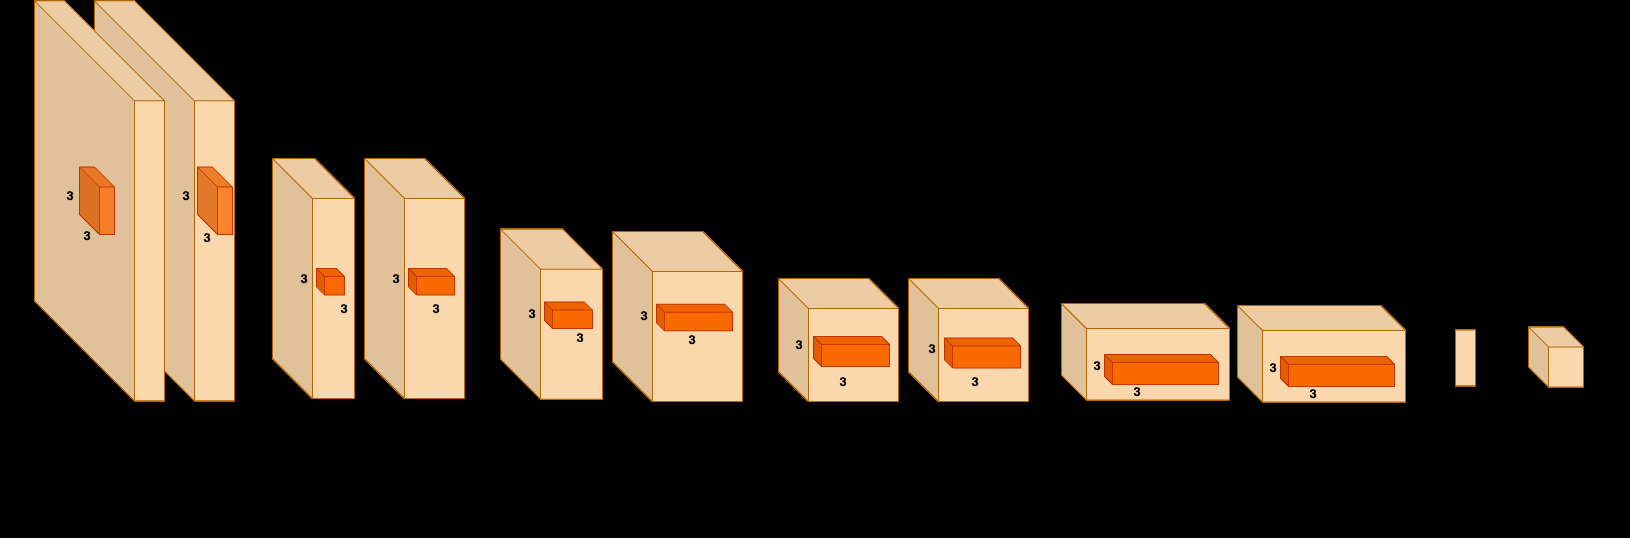

In [25]:
import io
from PIL import Image

img = Image.open(io.BytesIO(figures[0]))
display(img)

In [30]:
def determine_model_name(given_image=None):
  if given_image is None:
    return "gemini-pro"
  else:
    return "gemini-pro-vision"

def construct_image_part(given_image):
  return {
    "mime_type": "image/jpeg",
    "data": given_image
  }

def call_gemini(prompt="", API_KEY=None, given_text=None, given_image=None, generation_config=None, safety_settings=None):
  import google.generativeai as genai
  genai.configure(api_key=API_KEY)

  if generation_config is None:
    generation_config = {
      "temperature": 0.4,
      "top_p": 1,
      "top_k": 32,
      "max_output_tokens": 8192,
    }

  if safety_settings is None:
    safety_settings = [
      {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
    ]

  model_name = determine_model_name(given_image)
  model = genai.GenerativeModel(model_name=model_name,
                                generation_config=generation_config,
                                safety_settings=safety_settings)

  USER_PROMPT = f"""
  {prompt}
  ------------------------------------------------
  {given_text}
  """
  prompt_parts = [USER_PROMPT]
  if given_image is not None:
    prompt_parts.append(construct_image_part(given_image))

  response = model.generate_content(prompt_parts)
  return response.text

In [35]:
text =' '.join(texts)

In [49]:
summary_json = call_gemini(
    prompt='Below is an academic paper extracted from a PDF file. '
           'Come up with 10 questions ranging from basic to expert levels along with summarization. '
           'Give me your response by filling in the following JSON. '
           '{"title": text, "summary": text, "qa": [{"q": text, "a": text}, ...]}',
    given_text=text,
    API_KEY=GEMINI_API_KEY
)

In [60]:
summary_json

'{\n "title": "TinyissimoYOLO: A Quantized, Low-Memory Footprint, TinyML Object Detection Network for Low Power Microcontrollers",\n "summary": "This paper introduces TinyissimoYOLO, a quantized, memory-efficient, and ultra-lightweight object detection network suitable for edge processors with limited memory and computational resources. The proposed network is composed of quantized convolutional layers with 3x3 kernels and a fully connected layer at the output. It is designed to have a low memory footprint of less than 0.5 MB. The proposed network is trained and evaluated on the WiderFace dataset and a sub-set of the PascalVOC dataset. Furthermore, the network is deployed quantized and memory-efficient on different microcontrollers, such as the STM32H7A3 and STM32L4R9 from STMicroelectronics, Ambiq\\u2019s Apollo4b and on a novel microcontroller, MAX78000 from Analog Devices, which has a built-in CNN accelerator. The performance of the different architectures is compared and it is show

In [51]:
import json
summary = json.loads(summary_json)

In [59]:
for qas in summary['qa']:
  print(qas['q'])

What is the main contribution of this paper?
What are the key design decisions of the TinyissimoYOLO network?
How is the TinyissimoYOLO network trained and evaluated?
On which microcontrollers is the TinyissimoYOLO network deployed?
How does the MAX78000 microcontroller compare to the other microcontrollers in terms of performance?
What is the effect of mAP against relative object size dimensions within images?
What is the memory footprint of the TinyissimoYOLO network?
What is the input image size of the TinyissimoYOLO network?
What is the output layer size of the TinyissimoYOLO network?
What is the number of convolutional layers in the TinyissimoYOLO network?


In [53]:
fig0_desc = call_gemini(
    prompt=f'Below is the summary of the academic paper, {summary["title"]}. '
           'Based on the summary, give me the description of the given figure. '
           'Give me your response by filling in the following JSON. '
           '{"description": text}',
    given_text=summary['summary'],
    given_image=figures[0],
    API_KEY=GEMINI_API_KEY
)

In [61]:
fig0_desc

' {"description": "This figure shows the architecture of the proposed TinyissimoYOLO network. It consists of a stack of convolutional layers with 3x3 kernels and a fully connected layer at the output. The network is designed to have a low memory footprint and is suitable for edge processors with limited memory and computational resources."}'